# **Building Model** 

In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob
from sklearn.model_selection import train_test_split
import random

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
image_directory = '/content/gdrive/My Drive/Segmentation/GoldStdImages/'
mask_directory = '/content/gdrive/My Drive/Segmentation/MasksBW/'

In [ ]:
SIZE = 512
num_images = #Insert Number 

# Images and masks additional processing

In [ ]:
image_names = glob.glob("/content/gdrive/My Drive/Segmentation/GoldStdImages/*.jpg")
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img, 0) for img in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [ ]:
mask_names = glob.glob("/content/gdrive/My Drive/Segmentation/Masks/*.jpg")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [ ]:
#masking doesn't give strictly 1/0 pixel values so they are set manually based on cutoff value
index1 = 0
for i in mask_dataset:
 a = mask_dataset[index1]
 index1 += 1
 index2 = 0
 for j in i:
   b = a[index2]
   index2 += 1
   index3 = 0
   for k in j:
     c = b[index3]
     index3 += 1
     index4 = 0
     for l in k:
       if c[index4] < 9:
        c[index4] = 0
       elif c[index4] > 246:
         c[index4] = 255


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.30, random_state = 42)

**Scan and Mask side by side**

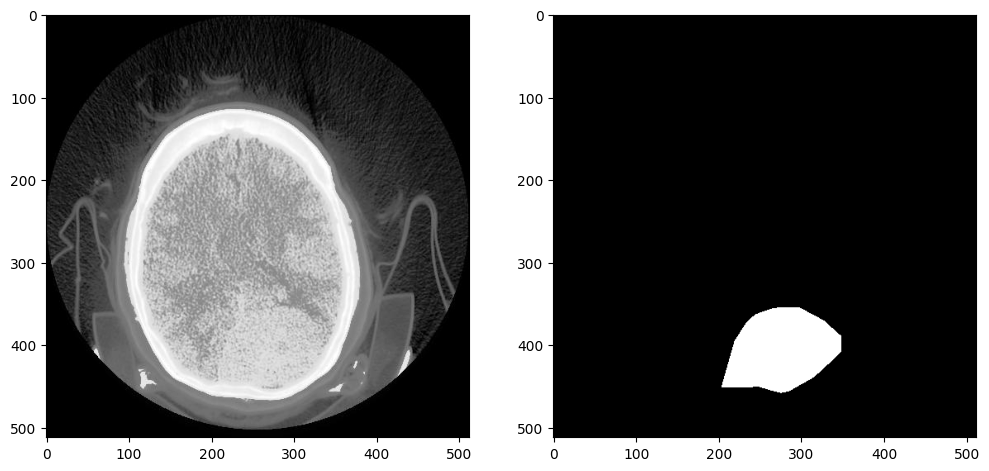

In [ ]:
image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

# U-Net

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def filters(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)
    return x



def encoder_block(input, num_filters):
    x = filters(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   



def decoder(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = filters(x, num_filters)
    return x



def get_model(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 2 * 64)
    s2, p2 = encoder_block(p1, 2 * 128)
    s3, p3 = encoder_block(p2, 2 * 256)
    s4, p4 = encoder_block(p3, 2 * 512)

    b1 = filters(p4, 2 * 1024) 

    d1 = decoder(b1, s4, 2 * 512)
    d2 = decoder(d1, s3, 2 * 256)
    d3 = decoder(d2, s2, 2 * 128)
    final_decoder = decoder(d3, s1, 2 * 64)

    outputs = Conv2D(n_classes, 2, activation = 'softmax', padding="same")(final_decoder)  

    model = Model(inputs, outputs, name = "Haemorrhage Segmentation")
    return model

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = get_model(input_shape, n_classes = 2)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Intersection over Union - measurement of success**

In [ ]:
from tensorflow.keras.metrics import MeanIoU

In [ ]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [ ]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("IoU = ", IOU_keras.result().numpy())

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction, cmap='gray')


plt.show()

**Notes**

In [ ]:
#defining training behaiour

# class MyModel(tf.keras.Model):

#   def __init__(self):
#     super().__init__()
#     self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
#     self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)
#     self.dropout = tf.keras.layers.Dropout(0.5)

#   def call(self, inputs, training=False):
#     x = self.dense1(inputs)
#     if training:
#       x = self.dropout(x, training=training)
#     return self.dense2(x)

# model = MyModel()

In [ ]:
#analyse single layer

#Model.get_layer(name=None, index=None)